In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from dt import DecisionTree

In [14]:
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score 

from sklearn.tree import DecisionTreeClassifier

In [3]:
from sklearn.datasets import load_digits
data = load_digits()
X, y = data.data, data.target

print(f'{X.shape=}')

X[0,:].reshape([8,8])
print(y)

X.shape=(1797, 64)
[0 1 2 ... 8 9 8]


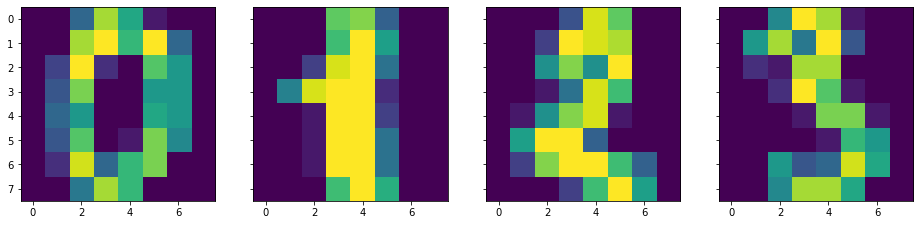

In [6]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):
    axes[i].imshow(X[i,:].reshape([8,8]))

Делим выборку на обучающую и тестовую

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

Обучаем самодельное решающее дерево

In [8]:
%%time
dt = DecisionTree(max_tree_depth=12, min_node_records=3)
dt.fit(x_train, y_train)

CPU times: user 6.09 s, sys: 5.34 ms, total: 6.1 s
Wall time: 6.1 s


Оцениваем результат обучения

In [9]:
y_train_pred = dt.predict(x_train)
y_test_pred = dt.predict(x_test)
accuracy_score(y_train_pred, y_train), accuracy_score(y_test_pred, y_test)

(0.9578361177406524, 0.8462962962962963)

Обучаем решающее дерево из sklearn

In [10]:
%%time
tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3, max_depth=12, random_state=177)
tree.fit(x_train, y_train)

CPU times: user 19.1 ms, sys: 7.22 ms, total: 26.3 ms
Wall time: 24.2 ms


DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=3,
                       random_state=177)

Оцениваем результат обучения

In [12]:
tree_train_pred = tree.predict(x_train)
tree_test_pred = tree.predict(x_test)
accuracy_score(tree_train_pred, y_train), accuracy_score(tree_test_pred , y_test)

(0.9578361177406524, 0.8407407407407408)

- Видно, что результаты сопоставимы, и как будто, у самодельного при прочих равных совсем чуть-чуть лучше точность на тестовой выборке, но это, скорее всего случайность, и при правильно подобраных параметрах (с помощью поиска по сетке) для обоих классификаторов реализация из sklearn должна, конечно, превзойти. 
- Кроме того, обучение самодельного решающего дерева происходит на несколько порядков дольше.

Дальше реализовал кросс-валидацию и поиск лучших параметров по сетке с помощью кросс валидации, но отладить пока не успел :(

In [13]:
def cross_validation(estimator_factory, X, cv=5, n_repeats=3):
    kf = RepeatedKFold(n_splits=cv, n_repeats=n_repeats, random_state=None) 

    metrics = []
    k = 0
    for train_index, test_index in kf.split(X):
        print(f'iter: {k}')

        X_trn, X_tst = X[train_index], X[test_index] 
        y_trn, y_tst = y[train_index], y[test_index]

        print(f'{X_trn.shape=}, {X_tst.shape=}')
        print(f'{y_trn.shape=}, {y_tst.shape=}')

        estimator = estimator_factory()
        estimator.fit(X_trn, y_trn)

        y_prd = estimator.predict(X_tst)


        print(f'{y_prd[:10]=}')
        print(f'{y_tst[:10]=}')
        accuracy = accuracy_score(y_prd, y_tst)
        print(f'{accuracy=}')
        metrics.append(accuracy)
        k += 1

    print(f'{metrics=}')
    return np.array(metrics)

def grid_search(X, max_tree_depths, min_node_records):
    best_accuracy = 0.0
    best_max_tree_depth = None
    best_min_node_records = None

    for mtd in max_tree_depths:
        for mnr in min_node_records:
            print(f'trying {mtd=}, {mnr=}')
            accuracy = np.mean(cross_validation(lambda: DecisionTree(max_tree_depth=mtd, min_node_records=mnr), X, cv=5, n_repeats=1))
            print(f'accuracy: {accuracy}')
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_max_tree_depth = mtd
                best_min_node_records = mnr

    return {'best_params' : (best_max_tree_depth, best_min_node_records), 'best_score' : best_accuracy }

In [ ]:
np.mean(cross_validation(lambda: DecisionTree(max_tree_depth=12, min_node_records=3), x_train, cv=5, n_repeats=1))

In [ ]:
np.mean(cross_val_score(tree, x_train, y_train, cv=5, scoring='accuracy'))

In [ ]:
max_tree_depths = [1, 5, 9]
min_node_records = [1, 5, 9]

grid_search(x_train, max_tree_depths, min_node_records)

In [ ]:
tree_params = {'min_samples_leaf': [1, 3, 5, 7, 9], 'min_samples_leaf': [1, 3, 5, 7, 9]}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(x_train, y_train)
tree_grid.best_params_, tree_grid.best_score_